
#### 1.1 How many goals were attempted by head
#### 1.2 How many matches had attendees more than 12000
#### 2.1 Shots list where goal was scored outside 16m box sorted by descending order
#### 2.2 Rank teams based on average attendance at home games 

In [1]:
from MongoStruct import *  

Database dropped


### Load all preprocessed data, dataframes and collections and show the Execution Time

In [2]:
@measure_execution_time
def MongoExecTime():
    return get_all_data()

print('----Loading Mongo----')
result, execution_time = MongoExecTime()  # Get both the result and execution time

# Unpack the 9 values from the result
client, shots_collection, matches_collection, players_collection, teams_collection, df_shots, df_matches, df_players, df_teams = result

----Loading Mongo----
shots Collection dropped
matches Collection dropped
players Collection dropped
teams Collection dropped
# shots documents: 245180
# matches documents: 14148
# players documents: 20414
# teams documents: 675
Execution time: 15.605189800262451 seconds


In [3]:
print(df_shots.columns)
# print(df_shots.head(5))
print(df_matches.columns)
# print(df_matches.head(5))
print(df_players.columns)
# print(df_players.head(-5))
print(df_teams.columns)
# print(df_teams.head(5))

Index(['Player', 'Outcome', 'Distance', 'Body Part', 'match_id'], dtype='object')
Index(['Date', 'league', 'Round', 'Day', 'Attendance', 'home_id', 'away_id',
       'score_away', 'score_home'],
      dtype='object')
Index(['id', 'Pos', 'Matches', 'club_id', 'MP', 'year', 'name'], dtype='object')
Index(['id', 'name', 'league', 'W', 'D', 'L', 'MP', 'GF', 'GA', 'GD', 'Pts'], dtype='object')


#### 1.1 How many goals were attempted by head

In [4]:
@measure_execution_time
def MongoQ1_1():
    # Define the query
    myquery = {"Outcome": "Goal" ,'Body Part':'Head'}
    # Execute the query
    result = shots_collection.find(myquery)
    print(result[0])
    cursor_list = list(result)
    print(f"Number of documents in cursor: {len(cursor_list)}")
    # # Print the results
    # for i in range(5):
    #     print(result[i])
    # print(results.alive)
    # print(type(results))
    print('Query 1.1')

result, execution_time=MongoQ1_1()

{'_id': ObjectId('674bce5250f8c788ecf6db9f'), 'Player': '4a1a9578', 'Outcome': 'Goal', 'Distance': 8.0, 'Body Part': 'Head', 'match_id': 'de515487'}
Number of documents in cursor: 3963
Query 1.1
Execution time: 0.14854860305786133 seconds


#### 1.2 How many matches had attendees more than 12000

In [5]:
@measure_execution_time
def MongoQ1_2():
    # Define the query
    myquery = {"Attendance":{"$gt": 12000}}

    # Execute the query
    result = matches_collection.find(myquery)

    print(result[0])

    # # Print the results
    # for i in range(5):
    #     print(result[i])

    # print(results.alive)
    # print(type(results))
    cursor_list = list(result)
    print(f"Number of documents in cursor: {len(cursor_list)}")

result, execution_time=MongoQ1_2()

{'_id': ObjectId('674bce5550f8c788ecfa995c'), 'Date': '2022-10-09', 'league': 11, 'Round': 11, 'Day': 'Sun', 'Attendance': 24671, 'home_id': '04eea015', 'away_id': '922493f3', 'score_away': 2, 'score_home': 2}
Number of documents in cursor: 9166
Execution time: 0.0440068244934082 seconds


#### 2.1 Total Goals Scoared and Inside VS Outside 16m box

In [6]:
@measure_execution_time
def MongoQ2_1():
    pipeline = [
        {
            '$match': {
                'Outcome': 'Goal'  # Filter only for documents where Outcome is 'Goal'
            }
        },
        {
            '$group': {
                '_id': {
                    'Player': '$Player',  # Group by Player
                    'Outcome': '$Outcome'  # Include Outcome in the grouping (always 'Goal')
                },
                'gt_16': {
                    '$sum': {
                        '$cond': [{'$gt': ['$Distance', 16]}, 1, 0]  # Count distances > 16
                    }
                },
                'total_goals': {'$sum': 1}  # Count the total goals for each player
            }
        },
        {
            '$addFields': {
                'lt_16': {'$subtract': ['$total_goals', '$gt_16']}  # Compute distances <= 16
            }
        },
        {
            '$sort': {'total_goals': -1}  # Sort by total_goals in descending order
        }
    ]

    # print(f"\nResults for GROUP query:")
    # print("Result before getting the names from id")

    result = list(shots_collection.aggregate(pipeline))

    df=pd.DataFrame(result)
    # df['id']=df['_id'].str.split(',').str[4]
    # result=result[:10]
    # for doc in result:
    #     print(f"Player: {doc['_id']['Player']}, Goals outside the box (> 16m): {doc['gt_16']}, Goals inside the box(< 16m): {doc['lt_16']}, Total goals scored: {doc['total_goals']}")

    # print(df)
    
    results_from_shots = list(shots_collection.aggregate(pipeline))

    # Extract unique player IDs from the previous query's output
    player_ids = [doc['_id']['Player'] for doc in results_from_shots]

    # Query to fetch player names based on the IDs
    player_lookup_query = {
        'id': {'$in': player_ids}  # Match IDs from players_collection
    }

    # Project only necessary fields (e.g., 'id' and 'name')
    player_projection = {
        '_id': 0,  # Exclude MongoDB's default _id field
        'id': 1,
        'name': 1
    }

    # Run the query on players_collection
    player_info = list(players_collection.find(player_lookup_query, player_projection))

    # Create a mapping of player IDs to names
    player_name_map = {player['id']: player['name'] for player in player_info}

    # Merge player names into the first query's result
    for doc in results_from_shots:
        player_id = doc['_id']['Player']
        doc['_id']['Name'] = player_name_map.get(player_id, 'Unknown')  # Add name or 'Unknown' if not found

    # Print the final merged result
    print("\nFinal Merged Results:")
    print("Result with the names")

    # results = results_from_shots[:10]
    # for doc in results:
    #     print(f"Name: {doc['_id']['Name']}, Goals scored: {doc['total_goals']}, Distance > 16m: {doc['gt_16']}, Distance < 16m: {doc['lt_16']}")

    df=pd.DataFrame(list(results_from_shots))
    df['Name'] = df['_id'].apply(lambda x: x['Name'])
    df=df.drop(columns=['_id'])
    df = df[['Name','total_goals','gt_16', 'lt_16']]
    # Sorting with Pandas
    # df=df.sort_values(by='total_goals',ascending=False)
    print(df.head(10))


result, execution_time=MongoQ2_1()


Final Merged Results:
Result with the names
                 Name  total_goals  gt_16  lt_16
0       Kylian-Mbappe          147     27    120
1  Robert-Lewandowski          146     15    131
2          Harry-Kane          120     21     99
3        Lionel-Messi          106     37     69
4       Ciro-Immobile          104     10     94
5       Mohamed-Salah          104     14     90
6       Karim-Benzema          104     16     88
7      Erling-Haaland          102      7     95
8   Wissam-Ben-Yedder           92      3     89
9    Lautaro-Martinez           89     15     74
Execution time: 0.3581414222717285 seconds


#### 2.2 Rank teams based on average attendance at home games

In [7]:
@measure_execution_time
def MongoQ2_2():
    pipeline_1 = [
        {
            '$group': {
                '_id': '$home_id',  # Group by home_id
                'average_attendance': {'$avg': '$Attendance'}, 
                'matches_count': {'$sum': 1}
            }},
        {
            '$sort': {'average_attendance': -1}
        }
    ]

    # print(f"\nResults for GROUP query:")
    result = list(matches_collection.aggregate(pipeline_1))
    # result=result[:10]
    # for doc in result:
    #     print(f"Home_id: {doc['_id']}, Average Attendace: {doc['average_attendance']:.1f}, Matches Count: {doc['matches_count']}")

    df=pd.DataFrame(list(result))
    # print(df.head(10))

    results_from_matches = list(matches_collection.aggregate(pipeline_1))
    # Extract unique teams IDs (adjusted based on `_id` type)
    home_ids = [doc['_id'] for doc in results_from_matches]

    # Query to fetch player names based on the IDs
    team_lookup_query = {
        'id': {'$in': home_ids}  # Match IDs from teams_collection
    }

    # Project only necessary fields (e.g., 'id' and 'name')
    team_projection = {
        '_id': 0,  # Exclude MongoDB's default _id field
        'id': 1,
        'name': 1
    }

    # Run the query on teams_collection
    team_info = list(teams_collection.find(team_lookup_query, team_projection))

    # Create a mapping of team IDs to names
    team_name_map = {team['id']: team['name'] for team in team_info}

    # Merge teams names into the first query's result
    for doc in results_from_matches:
        team_id = doc['_id']  
        doc['Name'] = team_name_map.get(team_id, 'Unknown')  # Add name or 'Unknown' if not found

    # Print the final merged result
    print("\nFinal Merged Results:")
    # results = results_from_matches[:10]
    # for doc in results:
    #     print(f"Team Name: {doc['Name']}, Average Attendance: {doc['average_attendance']:.0f}, Matches Count: {doc['matches_count']}")

    df=pd.DataFrame(list(results_from_matches))
    df=df[['Name','average_attendance','matches_count']]
    print(df.head(10))

result, execution_time=MongoQ2_2()


Final Merged Results:
                Name  average_attendance  matches_count
0  Manchester United        56407.227273            176
1           Dortmund        56036.021583            139
2            Benfica        54471.142857             14
3            Unknown        52851.000000              3
4       Hamburger SV        52331.000000              3
5          Barcelona        51691.458599            157
6      Bayern Munich        50702.652482            141
7            Unknown        48031.500000              8
8        Real Madrid        47265.540373            161
9    West Ham United        46952.068966            145
Execution time: 0.038008928298950195 seconds


#### 3 CREATE TABLES statements

In [8]:
# for i in Mongo_table_statements():
#     print(i)

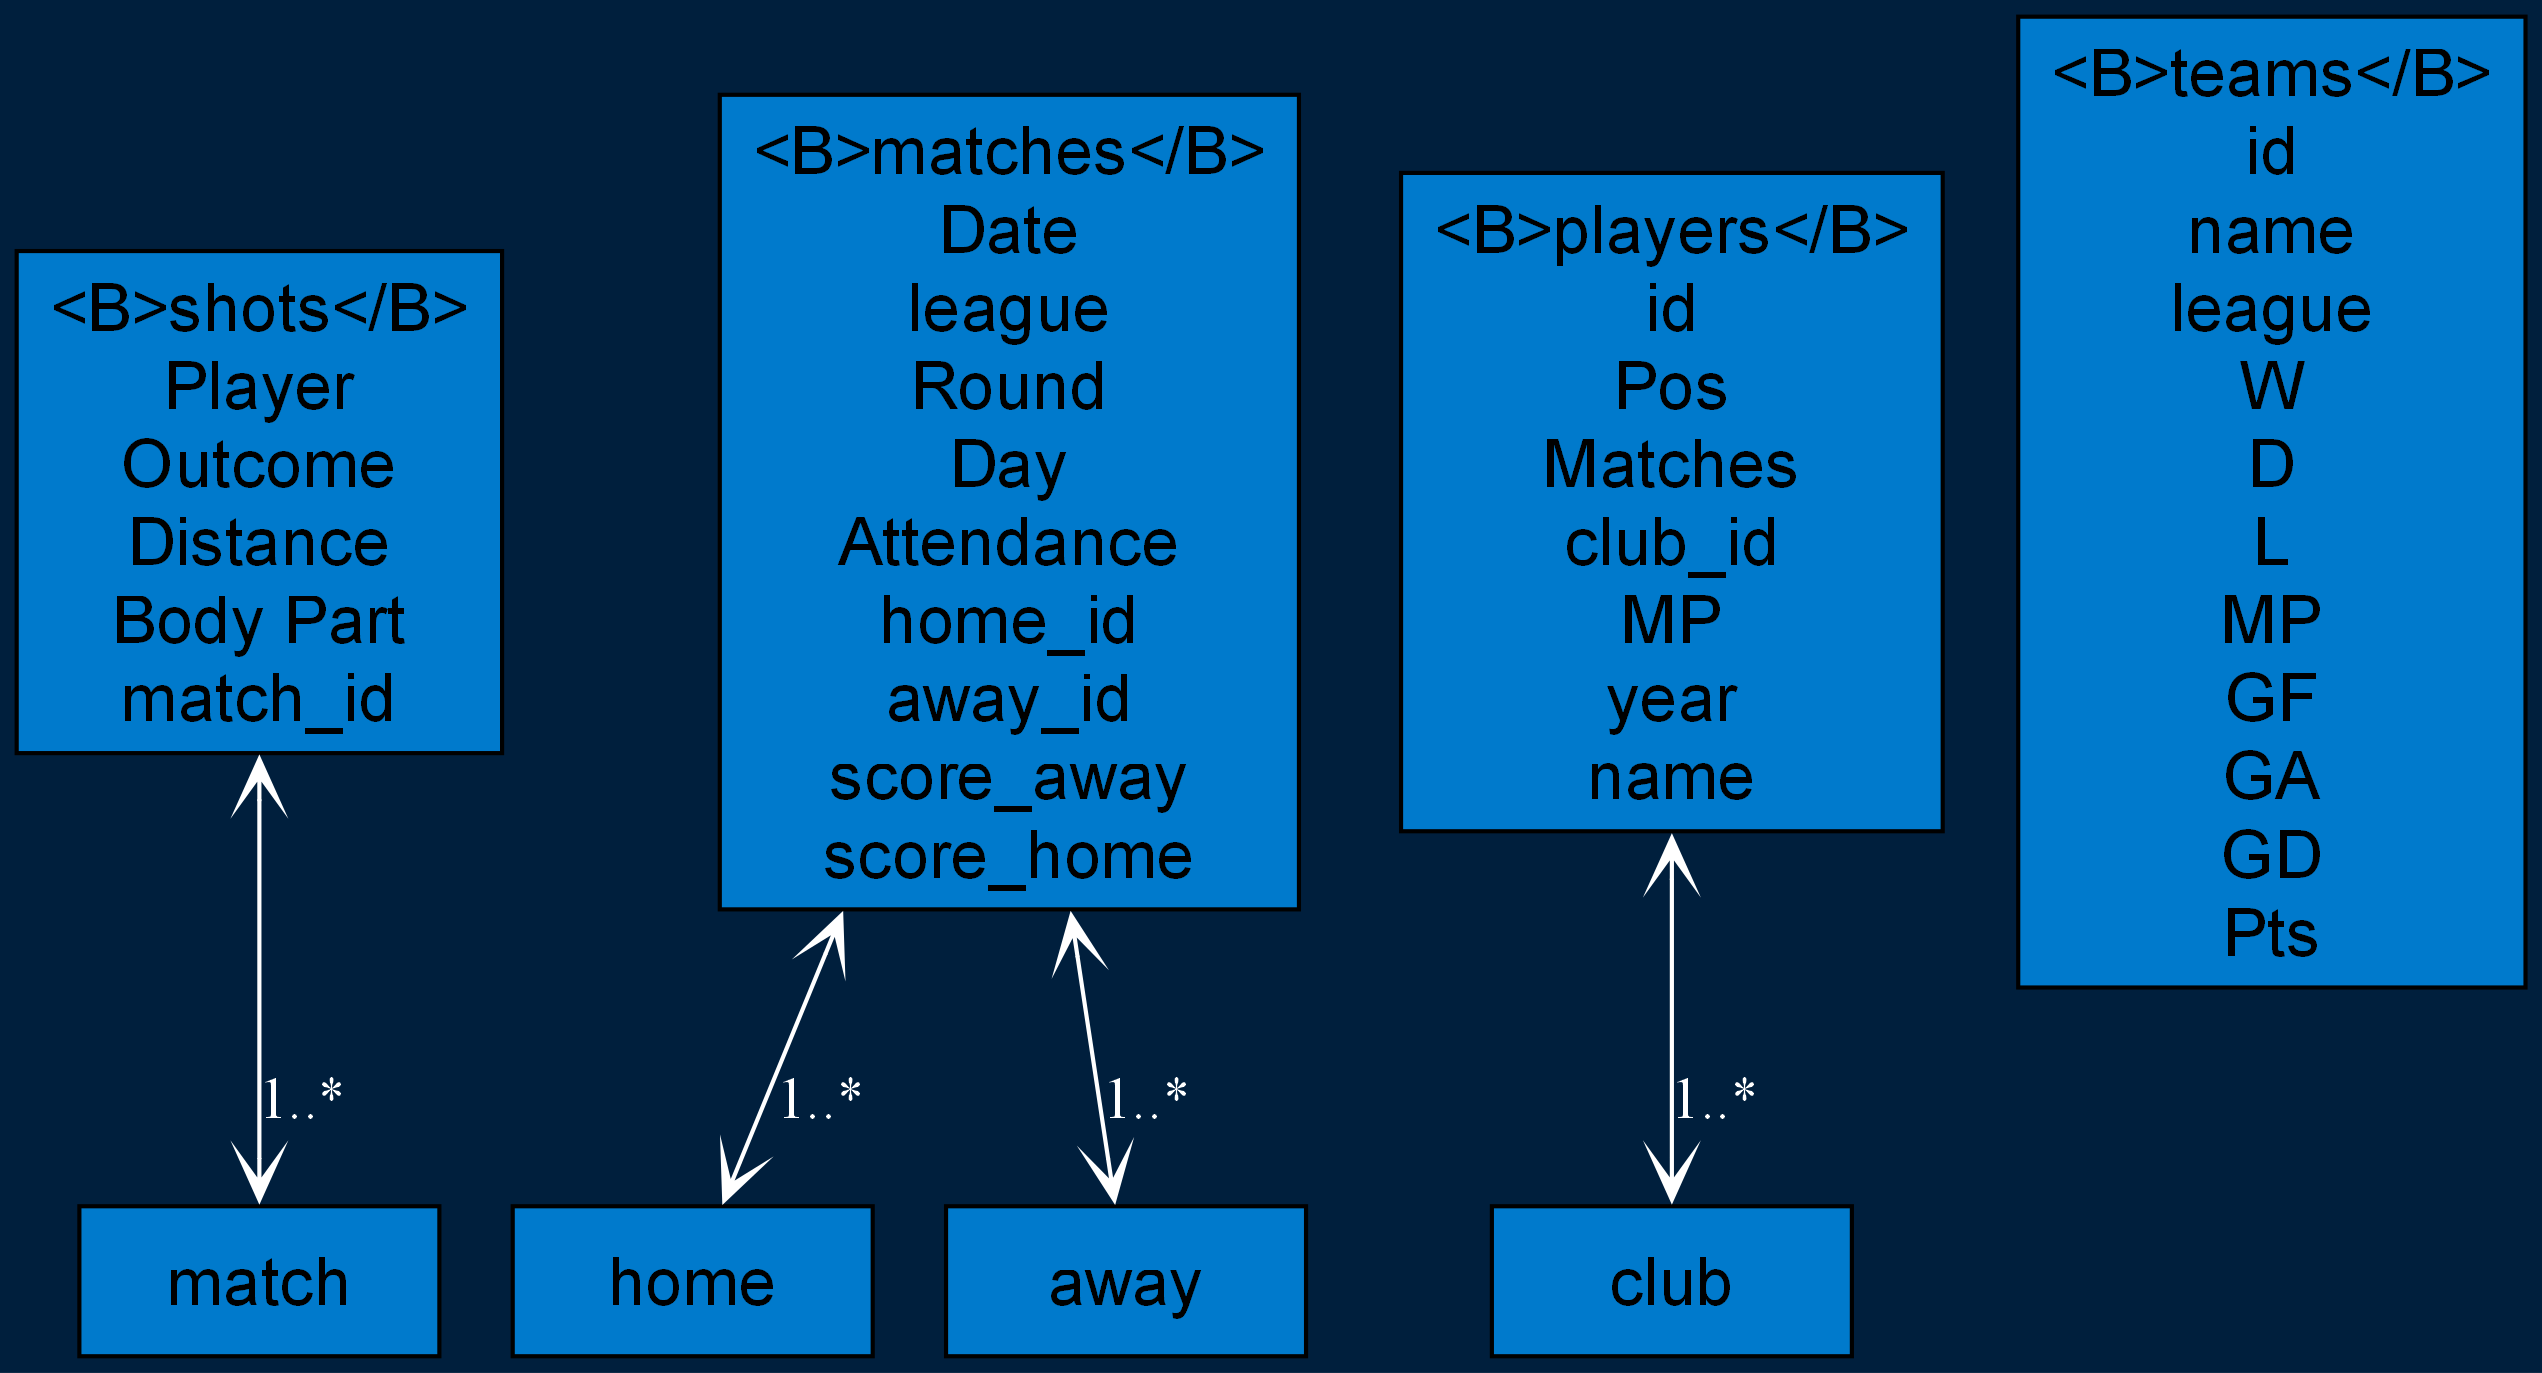

In [15]:
from graphviz import Digraph

# Function to generate ERD from MongoDB collections and their references
def generate_mongo_erd(collections_info):
    dot = Digraph(comment='MongoDB ERD', engine='dot')

    # Set graph background to dark blue and node box color to blue
    dot.attr(bgcolor='#001f3d', color='#FFFFFF')  # Dark blue background
    dot.attr('node', style='filled', fillcolor='#007acc', fontcolor='#000000', shape='box', width='1.2', fontsize='16', fontname='Helvetica')  # Increased fontsize
    dot.attr('edge', color='#FFFFFF', fontcolor='#FFFFFF')  # White cardinality labels

    # Set DPI for PNG rendering (300 DPI)
    dot.attr(dpi='300')

    # Iterate over the collections and add them to the ERD as nodes
    for collection_name, df in collections_info.items():
        # Create a formatted label with table name on top and columns listed below
        table_name_label = f"<B>{collection_name}</B>"  # Bold table name
        columns = "\n".join(df.columns)  # List the columns underneath
        label = f"{table_name_label}\n{columns}"
        
        # Add the node to the graph
        dot.node(collection_name, label=label)

    # Identify relationships (references) and add edges to ERD with cardinality and customized colors
    for collection_name, df in collections_info.items():
        references = find_references(collection_name, df)
        for ref in references:
            ref_collection = ref.split("_")[0]  # Assumes reference naming convention like `team_id`, `player_id`
            
            # Cardinality representation (adjust based on your logic)
            cardinality = '1..*'  # Default cardinality, you can change this depending on your data model
            if 'team' in ref_collection:
                cardinality = '1..*'  # Example: one team can have many shots
            elif 'player' in ref_collection:
                cardinality = '*..1'  # Example: one player can have many matches, but each match has one player
            
            # Add edge with cardinality label, set direction and arrow style
            dot.edge(collection_name, ref_collection, label=f"{cardinality}", dir='both', arrowhead='vee', arrowtail='vee')

    return dot

# Example usage
collections_info = {
    "shots": df_shots,
    "matches": df_matches,
    "players": df_players,
    "teams": df_teams
}

# Generate the ERD with increased DPI for PNG
erd_dot = generate_mongo_erd(collections_info)
erd_dot.render('mongodb_erd_with_high_resolution', format='png', view=False)  # DPI set in graph attributes

# To display in Jupyter
from IPython.display import Image
Image(filename='mongodb_erd_with_high_resolution.png')

